In [55]:
%pip install -q git+https://github.com/huggingface/transformers.git
%pip install -q datasets seqeval
%pip install layoutparser
%pip install layoutparser[ocr]
%pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
%pip install google-cloud-vision

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to c:\users\asus\appdata\local\temp\pip-install-k8d_ru7l\detectron2_68b556c80e1249d08c7ae2c4549c2ddc
  Resolved https://github.com/facebookresearch/detectron2.git to commit 82a57ce0b70057685962b352535147d9a8118578
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for detectron2
Failed to build detectron2
  Running setup.py install for detectron2: started
  Running setup.py install for detectron2: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git 'C:\Users\asus\AppData\Local\Temp\pip-install-k8d_ru7l\detectron2_68b556c80e1249d08c7ae2c4549c2ddc'
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [905 lines of output]
      No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2'
      running bdist_wheel
      C:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\cpp_extension.py:387: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
        warnings.warn(msg.format('we coul

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\asus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


[v]https://colab.research.google.com/drive/1EyOiwR04E36cn5NJ4TcO3UiKFrnl2DM4

## Auto Segmentation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
import os
import warnings
import numpy as np
import layoutparser as lp
from PIL import Image
import cv2
import json
from tqdm.notebook import tqdm
DIR = os.getcwd()

### Function

In [2]:
def resize_img(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

def contour_to_rect(contour,corner_tolerance=None):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    rect[0] *= (1-corner_tolerance)
    rect[1][0] *= (1+corner_tolerance)
    rect[1][1] *= (1-corner_tolerance)
    rect[2] *= (1+corner_tolerance)
    rect[3][0] *= (1-corner_tolerance)
    rect[3][1] *= (1+corner_tolerance)
    return rect

def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

def BlackWhiteImg(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(image=gray, block_size=5, offset=3)
    return (gray > T).astype("uint8") * 255

def normalize_bbox(bbox, size):
    return [
        int(bbox[0] * 1000 / size[1]),
        int(bbox[1] * 1000 / size[0]),
        int(bbox[2] * 1000 / size[1]),
        int(bbox[3] * 1000 / size[0]),
    ]

def unnormalize_bbox(bbox, size):
    return [
        int(bbox[0] * size[1] / 1000),
        int(bbox[1] * size[0] / 1000),
        int(bbox[2] * size[1] / 1000),
        int(bbox[3] * size[0] / 1000),
    ]

def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### Trial

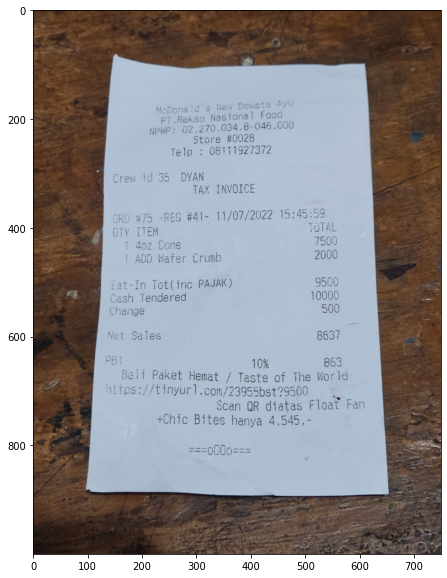

In [23]:
file_name = '20221123_233221.jpg'
file_path = os.path.join(DIR,'Nota',file_name)
img_read = cv2.imread(file_path)
img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
if img_read is None:
    raise Exception(f"Image {file_name} not found")
    
resize_ratio = 1000 / img_read.shape[0]
if resize_ratio > 1000 / img_read.shape[1]:
    resize_ratio = 1000 / img_read.shape[1]

img_read = cv2.rotate(img_read, cv2.ROTATE_90_CLOCKWISE)

img_rezise = resize_img(img_read, resize_ratio)
gray = cv2.cvtColor(img_rezise, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,10))
plt.imshow(img_rezise)
plt.show()

In [10]:
blurred = cv2.GaussianBlur(gray, (3, 3), 3)

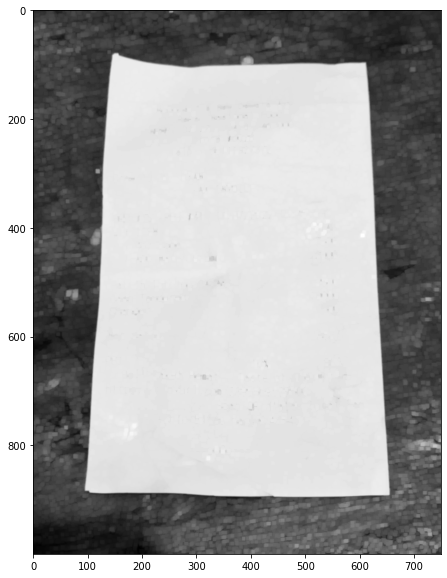

In [11]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
dilated = cv2.dilate(blurred, rectKernel)
plt.figure(figsize=(10,10))
plt.imshow(dilated, cmap='gray')
plt.show()
# thershold mengikuti histogram setelah itu cari terbesar lagi.

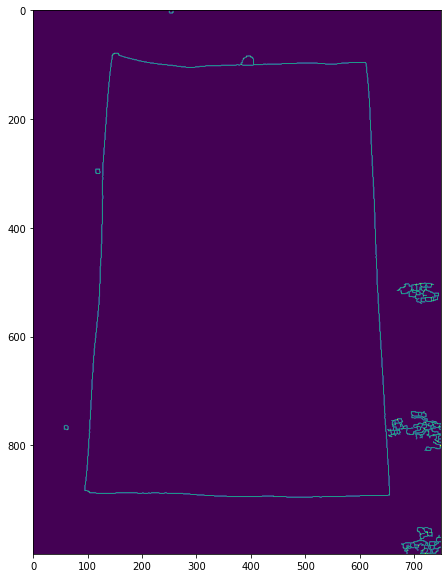

In [12]:
def auto_canny(image, sigma=1):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

edged = auto_canny(dilated)
plt.figure(figsize=(10,10))
plt.imshow(edged)
plt.show()

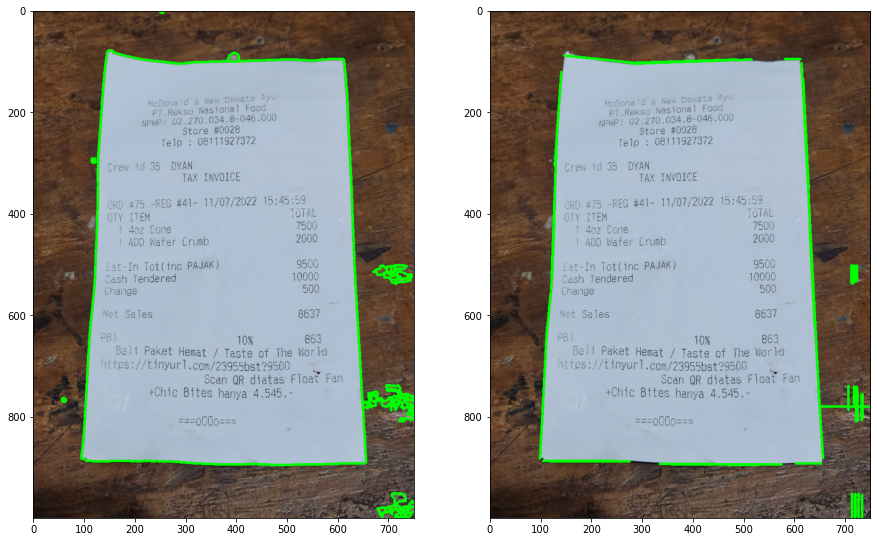

In [13]:
detected_lines = cv2.HoughLinesP(edged,rho = 0.5,theta = 1*np.pi/180,threshold = 30,minLineLength = 20,maxLineGap = 100)
edged_line = np.zeros_like(edged)
line_extender = 0
for line in detected_lines:
    x1, y1, x2, y2 = line[0]

    is_vertical = abs(x1 - x2) < abs(y1 - y2)
    if is_vertical: 
        x1 = int(x1-(abs(x1 - x2)/2*line_extender)*0.314)
        x2 = int(x2+(abs(x1 - x2)/2*line_extender)*0.314)

        if y1<y2:
            y1 = int(y1-(abs(y1 - y2)/2*line_extender))
            y2 = int(y2+(abs(y1 - y2)/2*line_extender))
        else:
            y1 = int(y1+(abs(y1 - y2)/2*line_extender))
            y2 = int(y2-(abs(y1 - y2)/2*line_extender))
    else:
        x1 = int(x1-(abs(x1 - x2)/2*line_extender))
        x2 = int(x2+(abs(x1 - x2)/2*line_extender))
        y1 = int(y1-(abs(y1 - y2)/2*line_extender)*0.314)
        y2 = int(y2+(abs(y1 - y2)/2*line_extender)*0.314)
    
    cv2.line(edged_line, (x1, y1), (x2, y2), (255), 1)

#main and backup method
contours_m, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy = cv2.findContours(edged_line, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

all_conturs_m = cv2.drawContours(img_rezise.copy(), contours_m, -1, (0,255,0), 3)
all_conturs_b = cv2.drawContours(img_rezise.copy(), contours_b, -1, (0,255,0), 3)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(all_conturs_m)
plt.subplot(1,2,2)
plt.imshow(all_conturs_b)
plt.show()

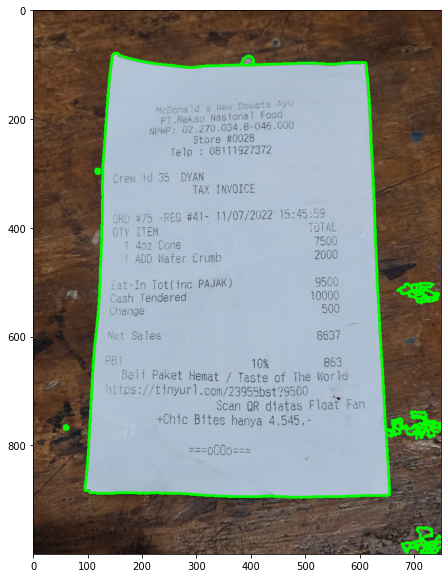

In [22]:
largest_contours = sorted(contours_m, key = cv2.contourArea, reverse = True)[:7]
image_with_largest_contours = cv2.drawContours(img_rezise.copy(), largest_contours, -1, (0,255,0), 3)
plt.figure(figsize=(10,10))
plt.imshow(image_with_largest_contours)
plt.show()

651 738 99 51
706 951 28 23
669 501 77 39
677 965 73 35
115 292 9 9
57 763 8 9
95 79 561 817
720 793 30 17
738 778 12 17
95 79 561 817


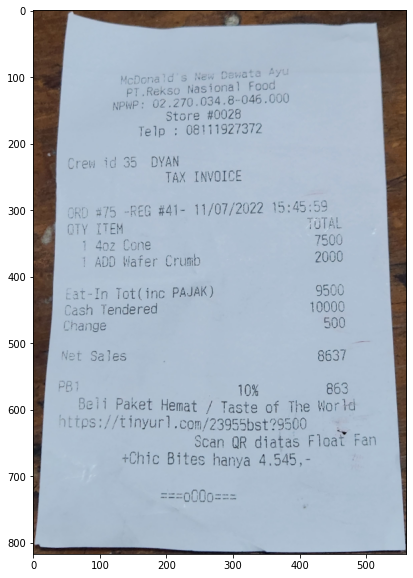

In [20]:
longest = 0
for i,cont in enumerate(largest_contours):
    x,y,w,h = cv2.boundingRect(largest_contours[i])

    cur_length = w+h
    print(x,y,w,h)
    if (cur_length>longest):
        longest = cur_length
        biggest_idx = i

x,y,w,h = cv2.boundingRect(largest_contours[biggest_idx])
print(x, y, w, h)
test = img_rezise.copy()
plt.figure(figsize=(10,10))
plt.imshow(img_rezise[y:y+h, x:x+w])
plt.show()
# cv2.imwrite(os.path.join(DIR,'Nota_Segmented',file_name),cv2.cvtColor(img_rezise[y:y+h, x:x+w], cv2.COLOR_RGB2BGR))

using backup method


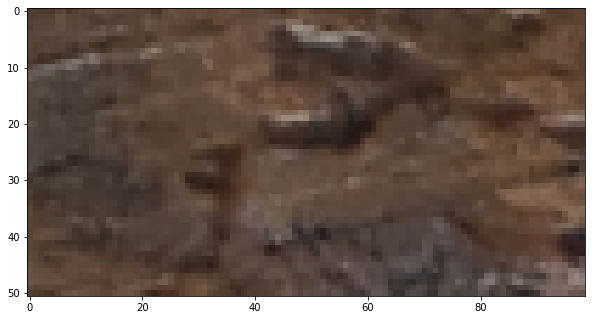

In [17]:

try:
    receipt_contour = get_receipt_contour(largest_contours)
    detected_receipt = cv2.drawContours(img_rezise.copy(), [receipt_contour], -1, (0, 255, 0), 2)
    result = wrap_perspective(img_rezise.copy(), contour_to_rect(receipt_contour,corner_tolerance = 0))
    print("using main method successfully")
except:
    print("using backup method")
    longest = 0
    for i,cont in enumerate(largest_contours):
        x,y,w,h = cv2.boundingRect(largest_contours[i])

        cur_length = w+h
        if (cur_length>longest):
            longest = cur_length
            biggest_idx = i
    x,y,w,h = cv2.boundingRect(largest_contours[biggest_idx])
    result = img_rezise[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()

## Read Data

Rotating Image :  482 513  to  513 482


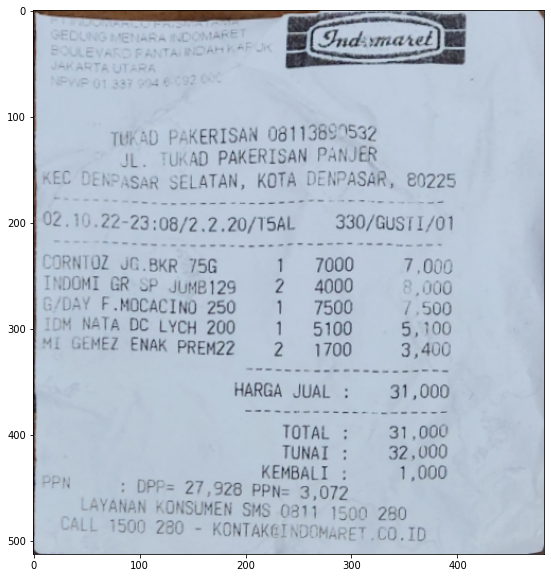

In [86]:
def prepareReceipt(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (3, 3), 3)
    rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(blurred, rectKernel)

    # edged = cv2.Canny(dilated, 30, 200, apertureSize=3)
    edged = auto_canny(dilated)
    contours_m, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contours = sorted(contours_m, key = cv2.contourArea, reverse = True)[0:4]
    image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
    
    try:
        receipt_contour = get_receipt_contour(largest_contours)
        result = wrap_perspective(image.copy(), contour_to_rect(receipt_contour,corner_tolerance = 0))
    except:
        longest = 0
        for i,cont in enumerate(largest_contours):
            x,y,w,h = cv2.boundingRect(largest_contours[i])

            cur_length = w+h
            if (cur_length>longest):
                longest = cur_length
                biggest_idx = i
        x,y,w,h = cv2.boundingRect(largest_contours[biggest_idx])
        result = image[y:y+h, x:x+w]

        if(result.shape[0]<125 or result.shape[1]<125):
            result = image.copy()
            warnings.warn("Warning Failed to Segment Image... Proceeding with default image")
        else:
            warnings.warn("Warning Failed to Segment Image... Proceeding with backup method")
    

    width, height, color = result.shape
    if width < height:
        print("Rotating Image : ", width, height," to ", height, width)
        result = cv2.rotate(result, cv2.ROTATE_90_CLOCKWISE)

    return result

def get_receipt(imgpath):
    img_read = cv2.imread(imgpath)
    img_read = cv2.cvtColor(img_read, cv2.COLOR_BGR2RGB)
    if img_read is None:
        raise Exception(f"Image {imgpath} not found")
        
    resize_ratio = 1000 / img_read.shape[0]
    if resize_ratio > 1000 / img_read.shape[1]:
        resize_ratio = 1000 / img_read.shape[1]
        
    img_rezise = resize_img(img_read, resize_ratio)
    return img_rezise

filename = 'Nota/20221123_230103.jpg'
image_result = prepareReceipt(get_receipt(filename))
# cv2.imwrite(os.path.join(DIR,'Nota_Segmented',filename),cv2.cvtColor(image_result, cv2.COLOR_RGB2BGR)) 'Nota/20221123_225935.jpg'
plt.figure(figsize=(10,10))
plt.imshow(image_result)
plt.show()



In [24]:
ocr_agent = lp.GCVAgent.with_credential(os.path.join(DIR,'gcv_credential.json'),
                                       languages = ['id'])
ocr_agent

In [25]:
res = ocr_agent.detect(img_rezise[y:y+h, x:x+w], return_response=True)
texts  = ocr_agent.gather_text_annotations(res)
    # collect all the texts without coordinates
# layout = ocr_agent.gather_full_text_annotation(res, agg_level=lp.GCVFeatureType.WORD)

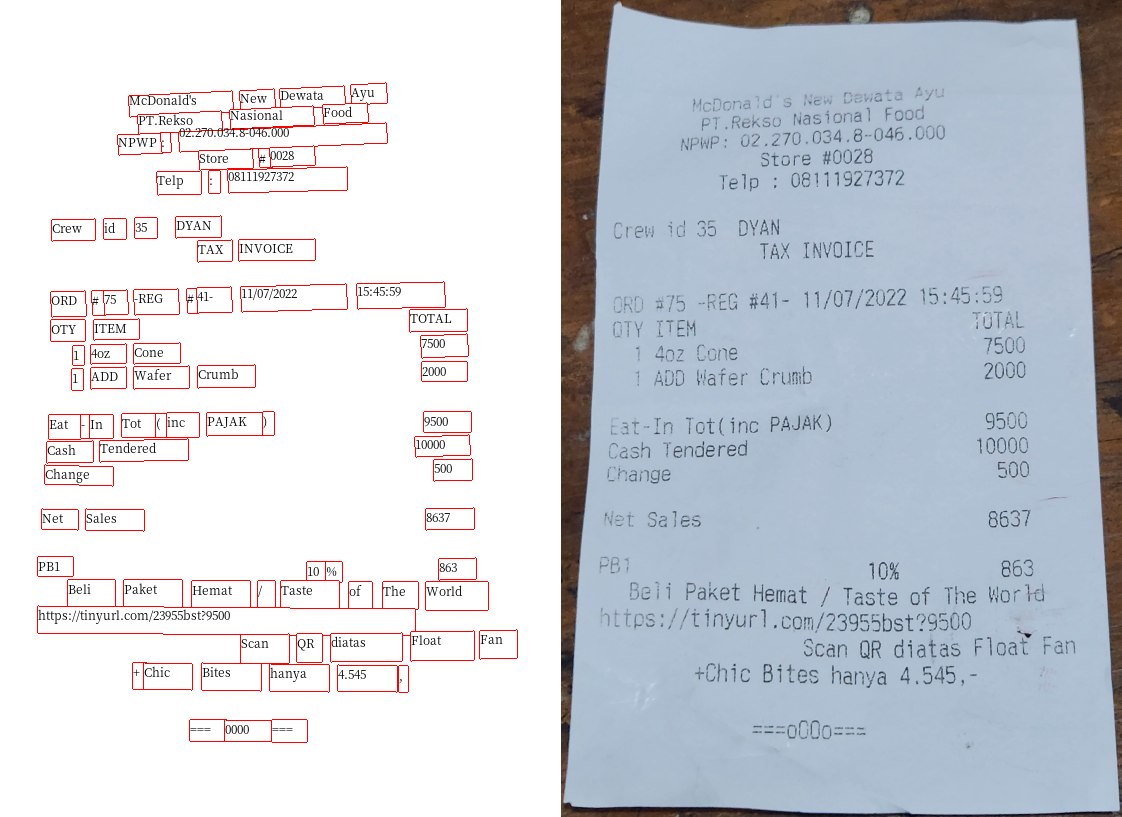

In [26]:
lp.draw_text(img_rezise[y:y+h, x:x+w], texts, font_size=12, with_box_on_text=True,
             text_box_width=3)

In [90]:
inference_words = []
for words_bbox in texts:
    inference_words.append(words_bbox.text)
inference_words

['GEDUNG',
 'MENARA',
 'INDOMARET',
 'BOULEVARD',
 'PANTAI',
 'INDAHKAPUK',
 'JAKARTA',
 'UTARA',
 'NPWP',
 '01',
 '337',
 '994',
 '6',
 ':',
 '092',
 '000',
 'Indamaret',
 'TUKAD',
 'PAKERISAN',
 '08113890532',
 'JL',
 '.',
 'TUKAD',
 'PAKERISAN',
 'PANJER',
 'KEC',
 'DENPASAR',
 'SELATAN',
 ',',
 'KOTA',
 'DENPASAR',
 ',',
 '80225',
 '330',
 '/',
 'GUSTI',
 '/',
 '01',
 '1',
 '02.10.22-23',
 ':',
 '08',
 '/',
 '2.2.20',
 '/',
 '15AL',
 '7000',
 '2',
 '4000',
 'CORNTOZ',
 'JG.BKR',
 '75G',
 'INDOMI',
 'GR',
 'SP',
 'JUMB',
 '129',
 'G',
 '/',
 'DAY',
 'F.MOCACINO',
 '250',
 'IDM',
 'NATA',
 'DC',
 'LYCH',
 '200',
 '1',
 '5100',
 'MI',
 'GEMEZ',
 'ENAK',
 'PREM22',
 '2',
 '1700',
 '1',
 '7500',
 'HARGA',
 'JUAL',
 ':',
 'TOTAL',
 ':',
 'TUNAI',
 ':',
 'KEMBALI',
 ':',
 'PPN',
 ':',
 'DPP',
 '=',
 '27,928',
 'PPN',
 '=',
 '3,072',
 'LAYANAN',
 'KONSUMEN',
 'SMS',
 '0811',
 '1500',
 '280',
 'CALL',
 '1500',
 '280',
 'KONTAK@INDOMARET.CO.ID',
 '7,000',
 '8,000',
 '7,500',
 '5,100',
 '3,40

In [91]:
texts[5]

TextBlock(block=Quadrilateral(points=[[140  29]
 [224  27]
 [224  42]
 [140  44]], width=84, height=17), text=INDAHKAPUK, id=5, type=None, parent=None, next=None, score=None)

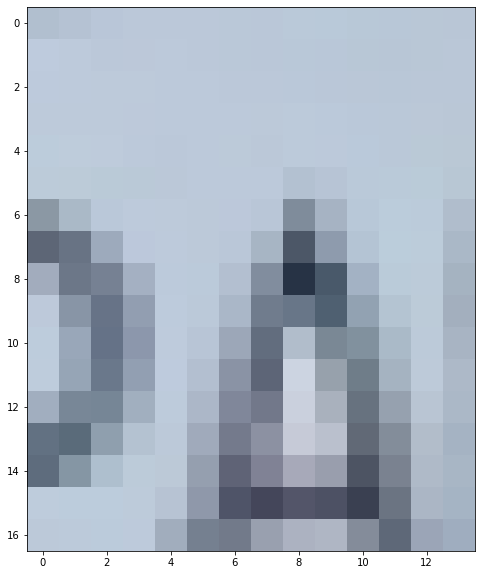

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(image_result[126:143, 180:194])
plt.show()

what i need [1]:[3],[0]:[2]

[180:196, 49:91]

[49,180,91,196]

In [96]:
np.min(texts[5].block.points, axis=0)
np.max(texts[5].block.points, axis=0)

array([224,  44])

In [97]:
inference_boxes = []
for words_bbox in texts:
    h = np.min(words_bbox.block.points, axis=0)
    w = np.max(words_bbox.block.points, axis=0)
    inference_boxes.append([h[0],h[1],w[0],w[1]])
inference_boxes

[[17, 18, 67, 30],
 [72, 18, 124, 29],
 [127, 17, 201, 29],
 [15, 30, 91, 47],
 [95, 29, 140, 45],
 [140, 27, 224, 44],
 [16, 45, 71, 57],
 [75, 47, 115, 58],
 [16, 60, 51, 74],
 [55, 60, 68, 73],
 [73, 60, 93, 72],
 [97, 59, 117, 72],
 [121, 59, 128, 71],
 [127, 59, 132, 71],
 [132, 59, 153, 71],
 [156, 58, 177, 70],
 [272, 19, 376, 34],
 [72, 109, 116, 128],
 [127, 107, 210, 127],
 [220, 105, 322, 125],
 [81, 132, 99, 148],
 [102, 132, 107, 147],
 [118, 130, 164, 147],
 [173, 128, 257, 146],
 [266, 127, 323, 143],
 [8, 151, 35, 168],
 [46, 151, 117, 168],
 [129, 151, 191, 168],
 [196, 151, 199, 168],
 [212, 151, 247, 168],
 [258, 151, 333, 168],
 [336, 151, 340, 168],
 [353, 151, 398, 168],
 [285, 191, 313, 209],
 [313, 191, 322, 209],
 [323, 191, 368, 209],
 [369, 191, 378, 209],
 [379, 191, 395, 210],
 [230, 232, 236, 248],
 [9, 190, 108, 209],
 [113, 190, 116, 208],
 [119, 190, 136, 208],
 [137, 190, 145, 208],
 [146, 190, 201, 208],
 [202, 191, 210, 209],
 [210, 191, 247, 209],
 

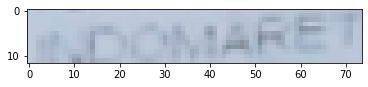

should read INDOMARET


In [101]:
i = 2
ex_text = inference_words[i]
ex_box = inference_boxes[i]

plt.imshow(image_result[ex_box[1]:ex_box[3], ex_box[0]:ex_box[2]])
plt.show()
print(f"should read {ex_text}")

## Segment All

In [103]:
## Dont Change The Orientation... It will mess up the coordinates
from tqdm import tqdm_notebook as tqdm
for filename in tqdm(os.listdir('Nota')):
    print("Working on : ", filename)
    filepath = os.path.join(DIR,'Nota',filename)
    image_result = prepareReceipt(get_receipt(filepath))
    cv2.imwrite(os.path.join(DIR,'Nota_Segmented',filename),cv2.cvtColor(image_result, cv2.COLOR_RGB2BGR))

C:\Users\asus\AppData\Local\Temp\ipykernel_2140\3642896740.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm(os.listdir('Nota')):


  0%|          | 0/51 [00:00<?, ?it/s]

C:\Users\asus\AppData\Local\Temp\ipykernel_2140\1945140197.py:33: UserWarning: Warning Failed to Segment Image... Proceeding with backup method
  warnings.warn("Warning Failed to Segment Image... Proceeding with backup method")


Working on :  20221013_192759.jpg
Working on :  20221123_225136.jpg
Working on :  20221123_225518.jpg
Working on :  20221123_225657.jpg
Rotating Image :  367 483  to  483 367
Working on :  20221123_225827.jpg
Working on :  20221123_225910.jpg
Rotating Image :  331 579  to  579 331
Working on :  20221123_225935.jpg
Rotating Image :  478 798  to  798 478
Working on :  20221123_230004.jpg
Rotating Image :  462 725  to  725 462
Working on :  20221123_230103.jpg
Rotating Image :  482 513  to  513 482
Working on :  20221123_230200.jpg
Rotating Image :  446 642  to  642 446
Working on :  20221123_230259.jpg
Working on :  20221123_230408.jpg
Rotating Image :  397 727  to  727 397
Working on :  20221123_230604.jpg
Rotating Image :  424 473  to  473 424
Working on :  20221123_230700.jpg
Working on :  20221123_230737.jpg
Rotating Image :  463 678  to  678 463
Working on :  20221123_230854.jpg
Rotating Image :  524 525  to  525 524
Working on :  20221123_230906.jpg
Working on :  20221123_230919.jp

C:\Users\asus\AppData\Local\Temp\ipykernel_2140\1945140197.py:31: UserWarning: Warning Failed to Segment Image... Proceeding with default image
  warnings.warn("Warning Failed to Segment Image... Proceeding with default image")


Rotating Image :  750 1000  to  1000 750
Working on :  20221123_232908.jpg
Rotating Image :  570 724  to  724 570
Working on :  20221123_232941.jpg
Rotating Image :  598 790  to  790 598
Working on :  20221123_233042.jpg
Rotating Image :  606 672  to  672 606
Working on :  20221123_233221.jpg
Working on :  20221123_233617.jpg
Rotating Image :  385 921  to  921 385
Working on :  20221123_233933.jpg
Working on :  20221123_234116.jpg
Rotating Image :  7 8  to  8 7
Working on :  20221123_234327.jpg
Working on :  20221123_234406.jpg
Rotating Image :  750 1000  to  1000 750
Working on :  20221123_234533.jpg
Rotating Image :  44 45  to  45 44
Working on :  20221123_234747.jpg
Working on :  20221123_234829.jpg
Rotating Image :  576 595  to  595 576
Working on :  20221123_234845.jpg
Rotating Image :  614 621  to  621 614
Working on :  20221123_234904.jpg
Rotating Image :  570 617  to  617 570
Working on :  20221123_235103.jpg


## Annotate All

- check size before annotate

In [236]:
for filename in tqdm(os.listdir('Nota_Segmented')):
    test_img = cv2.imread(os.path.join(DIR,'Nota_Segmented',filename))
    x,y,_ = test_img.shape
    if(x > 1000) or (y > 1000):
        raise Exception(f"Image {filename} is too large")

print("All images are good to go")

C:\Users\asus\AppData\Local\Temp\ipykernel_2140\189129552.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm(os.listdir('Nota_Segmented')):


  0%|          | 0/51 [00:00<?, ?it/s]

All images are good to go


In [237]:
ocr_agent = lp.GCVAgent.with_credential(os.path.join(DIR,'gcv_credential.json'), languages = ['id'])

for filename in tqdm(os.listdir('Nota_Segmented')):
    filepath = os.path.join(DIR,'Nota_Segmented',filename)
    image_result = get_receipt(filepath)
    res = ocr_agent.detect(image_result, return_response=True)
    texts  = ocr_agent.gather_text_annotations(res)
    
    inference_words = []
    for words_bbox in texts:
        inference_words.append(words_bbox.text)

    inference_boxes = []
    for words_bbox in texts:
        h = np.min(words_bbox.block.points, axis=0)
        w = np.max(words_bbox.block.points, axis=0)
        inference_boxes.append([h[0],h[1],w[0],w[1]])

    receipt_json = {}
    receipt_json['file_name'] = filename
    receipt_json['size'] = image_result.shape
    receipt_json['bboxes'] = [normalize_bbox(box, image_result.shape) for box in inference_boxes]
    receipt_json['words'] = inference_words
    receipt_json['labels'] = [0]*len(inference_words)

    with open(f"Annotation/{filename.split('.jpg')[0]}.json", "w") as outfile:
        json.dump(receipt_json, outfile)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
# for filename in os.listdir('Annotation'):
#     filename = filename.split('.json')[0]
#     try:
#         with open(os.path.join(DIR,'Annotation',f'{filename}.json')) as f:
#             data = json.load(f)
#             data = data[filename+'.jpg']

#         receipt_json = {}
#         receipt_json['file_name'] = data['file_name']
#         receipt_json['size'] = data['size']
#         receipt_json['bboxes'] = data['bboxes']
#         receipt_json['words'] = data['words']
#         receipt_json['labels'] = [0]*len(data['words'])
#         # receipt_list[filename] = receipt_json
#         with open(f"Annotation/{filename}.json", "w") as outfile:
#             json.dump(receipt_json, outfile)
#     except:
#         print(f"File {filename} not found")

File 20221013_192759 not found
File 20221123_225136 not found
File 20221123_225518 not found
File 20221123_225657 not found
File 20221123_225827 not found
File 20221123_225910 not found
File 20221123_225935 not found
File 20221123_230004 not found
File 20221123_230103 not found
File 20221123_230200 not found
File 20221123_230259 not found
File 20221123_230408 not found
File 20221123_230604 not found
File 20221123_230700 not found
File 20221123_230737 not found
File 20221123_230854 not found
File 20221123_230906 not found
File 20221123_230919 not found
File 20221123_230954 not found
File 20221123_231206 not found
File 20221123_231405 not found
File 20221123_231751 not found
File 20221123_231825 not found
File 20221123_231855 not found
File 20221123_231907 not found
File 20221123_231932 not found
File 20221123_231956 not found
File 20221123_232013 not found
File 20221123_232200 not found
File 20221123_232243 not found
File 20221123_232323 not found
File 20221123_232343 not found
File 202

In [1]:
def annot_helper(
    file_name:str,
    bboxes:list,
    words:list,
    batch_num:int):
    '''
    batch num starts from 1 and there's 10 images to annotate per batch
    '''

    batch_num -= 1
    file_name = file_name.split('.json')[0]+'.jpg'
    img = cv2.imread(os.path.join(DIR,'Nota_Segmented',file_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ex_box = []
    for bbox in bboxes:
        bbox = unnormalize_bbox(bbox, img.shape)
        ex_box.append(bbox)

    ex_word = words[batch_num*10:(batch_num+1)*10]
    ex_box = ex_box[batch_num*10:(batch_num+1)*10]

    for box in ex_box:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 1)
    plt.figure(figsize=(10,10))
    plt.imshow(img)

    plt.figure(figsize=(20,10))
    for i in range(len(ex_word)):
        plt.subplot(2,5,i+1)
        plt.imshow(img[ex_box[i][1]:ex_box[i][3], ex_box[i][0]:ex_box[i][2]])
        plt.title(ex_word[i])
    plt.show()

    batch_length = len(bboxes)/10 if len(words) % 10 == 0 else len(bboxes)//10 + 1
    print(f"there are {batch_length} batch to review ({batch_num+1}/{batch_length}) ")

In [2]:
filelist = []
for i in os.listdir('Annotation'):
    filelist.append(i)

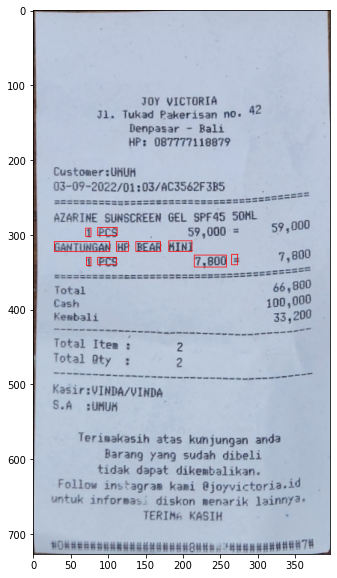

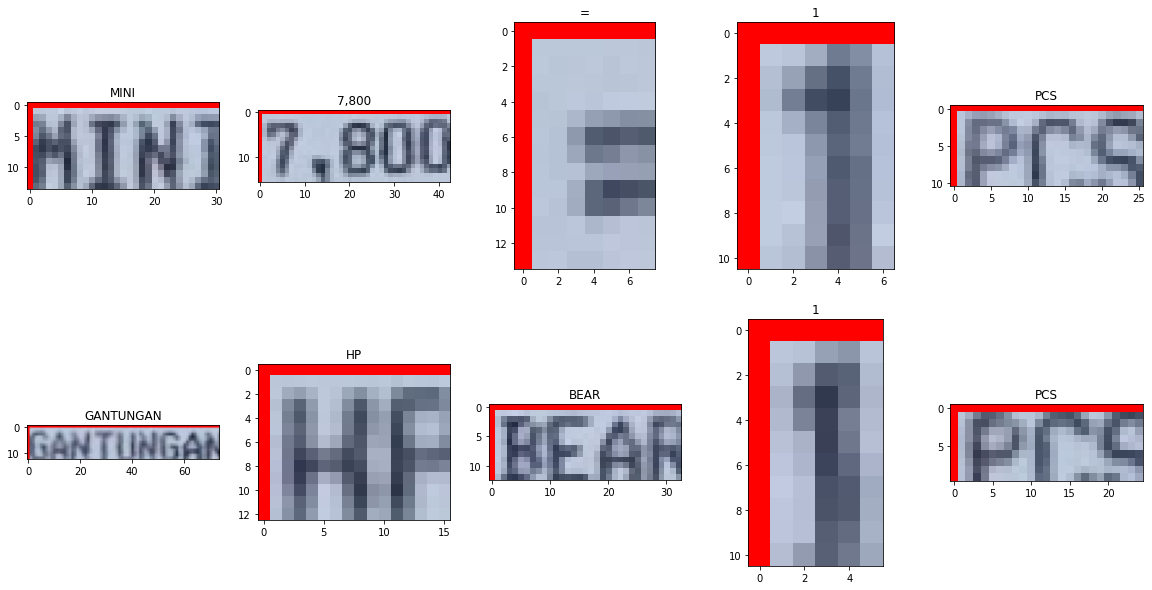

there are 10.0 batch to review (4/10.0) 


In [9]:
# Nota_Segmented\20221123_225935.jpg
file_name = filelist[9]
with open(os.path.join(DIR,'Annotation',file_name)) as f:
    data = json.load(f)
    
annot_helper(file_name,data['bboxes'],data['words'],batch_num=4)

In [86]:
a1=[0,0,0,2,0,
0,0,0,0,0]

a2=[1,1,0,0,0,
0,0,0,0,0]

a3=[0,0,0,5,5,
5,5,5,8,14]

a4=[5,8,14,7,14,
5,5,5,7,14]

a5=[0,12,14,14,14,
14,14,14,14,14]

a6=[0,0,0,0,0,
0,0,0,14,14]

a7=[0,0,0,9,9,
13,14,14,0,0]

a8=[0,0,0,0,0,
0,0,0,0,0]

a9=[0,0,0,0,0,
0,0,0,0,0]

a10=[0,0,0,0,0,
0,0,0,0,0]

# a11=[14,14,14,14,14,
# 14,14,14,14,14]

# a12=[14,14]

labels = a1+a2+a3+a4+a5+a6+a7+a8+a9+a10

{0: 'Ignore', 
1: 'Store_name_value', 1 
2: 'Store_name_key', 0
3: 'Store_addr_value', 0
4: 'Store_addr_key', 0
5: 'Tel_value', 0
6: 'Tel_key', 0
7: 'Date_value', 2
8: 'Date_key', 0
9: 'Time_value', 3 
10: 'Time_key', 0
12: 'Prod_item_key', 4
11: 'Prod_item_value', 5
14: 'Prod_quantity_key', 6
13: 'Prod_quantity_value', 7
16: 'Prod_price_key', 8
15: 'Prod_price_value', 9
18: 'Subtotal_key', 10
17: 'Subtotal_value', 11
20: 'Tax_key', 0
19: 'Tax_value', 0
21: 'Tips_value', 0
22: 'Tips_key', 0
24: 'Total_key', 12
23: 'Total_value', 13 
25: 'Others'}, 14

{0: 'Ignore'
1: 'Store_name_value' 
2: 'Store_name_key'
3: 'Store_addr_value'
4: 'Store_addr_key'
5: 'Tel_value'
6: 'Tel_key'
7: 'Date_value'
8: 'Date_key'
9: 'Time_value' 
10: 'Time_key'
12: 'Prod_item_key'
11: 'Prod_item_value'
14: 'Prod_quantity_key'
13: 'Prod_quantity_value'
16: 'Prod_price_key'
15: 'Prod_price_value'
18: 'Subtotal_key'
17: 'Subtotal_value'
20: 'Tax_key'
19: 'Tax_value'
21: 'Tips_value'
22: 'Tips_key'
24: 'Total_key'
23: 'Total_value'
25: 'Others'}

In [25]:
def updateLabel(fn,labels):
    fn = fn.split('.json')[0]
    try:
        with open(os.path.join(DIR,'Annotation',f'{fn}.json')) as f:
            data = json.load(f)

        receipt_json = {}
        receipt_json['file_name'] = data['file_name']
        receipt_json['size'] = data['size']
        receipt_json['bboxes'] = data['bboxes']
        receipt_json['words'] = data['words']
        receipt_json['labels'] = labels
        
        with open(f"Annotation/{fn}.json", "w") as outfile:
            json.dump(receipt_json, outfile)
        print(f"File {os.path.join(DIR,'Annotation',f'{fn}.json')} updated successfully")

        with open(f"labeling_done.json","r") as open_tracker:
            done_update = json.load(open_tracker)
        done_update[data['file_name']] = 1

        with open(f"labeling_done.json", "w") as closed_tracker:
            json.dump(done_update, closed_tracker)
    except:
        print(f"File {os.path.join(DIR,'Annotation',f'{fn}.json')} not found")

In [87]:
updateLabel(file_name,labels)

File d:\Andre\TA\Indonesian-Receipt-Detector-using-LayoutLM\Annotation\20221123_230408.json updated successfully


## Updated_dataset


In [88]:
with open(f"labeling_done.json","r") as open_tracker:
    done_update = json.load(open_tracker)
print(f"there's {len(done_update.keys())} files done")
print(done_update.keys())

there's 10 files done
dict_keys(['20221013_192759.jpg', '20221123_225136.jpg', '20221123_225827.jpg', '20221123_225657.jpg', '20221123_225935.jpg', '20221123_230004.jpg', '20221123_230103.jpg', '20221123_230200.jpg', '20221123_230259.jpg', '20221123_230408.jpg'])
